# Кусовой проект
### Курс: Библиотеки Python для Data Science

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)


#### Содержание
1. Подключение библиотек
2. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Балансировка классов
6. Подбор моделей, получение бейзлана
7. Выбор наилучшей модели, настройка гиперпараметров
8. Проверка качества, борьба с переобучением

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

#### Подключение библиотек

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline
import warnings
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import catboost as catb

warnings.filterwarnings('ignore')

In [229]:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'
OUTPUT_PREDICTIONS_PATH = './EAfonin_solutions.csv'
OUTPUT_DATA_PATH = './EAfonin_solutions_data.csv'
TARGET = 'Credit Default'

### Обзор обучающего датасета

In [4]:
ds = pd.read_csv(TRAIN_DATASET_PATH)
ds.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [5]:
ds.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [7]:
ds.shape

(7500, 17)

In [9]:
object_columns = ds.select_dtypes(include=['object']).columns
float_columns = ds.select_dtypes(include=['float64']).columns
object_columns, float_columns

(Index(['Home Ownership', 'Years in current job', 'Purpose', 'Term'], dtype='object'),
 Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
        'Years of Credit History', 'Maximum Open Credit',
        'Number of Credit Problems', 'Months since last delinquent',
        'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
        'Monthly Debt', 'Credit Score'],
       dtype='object'))

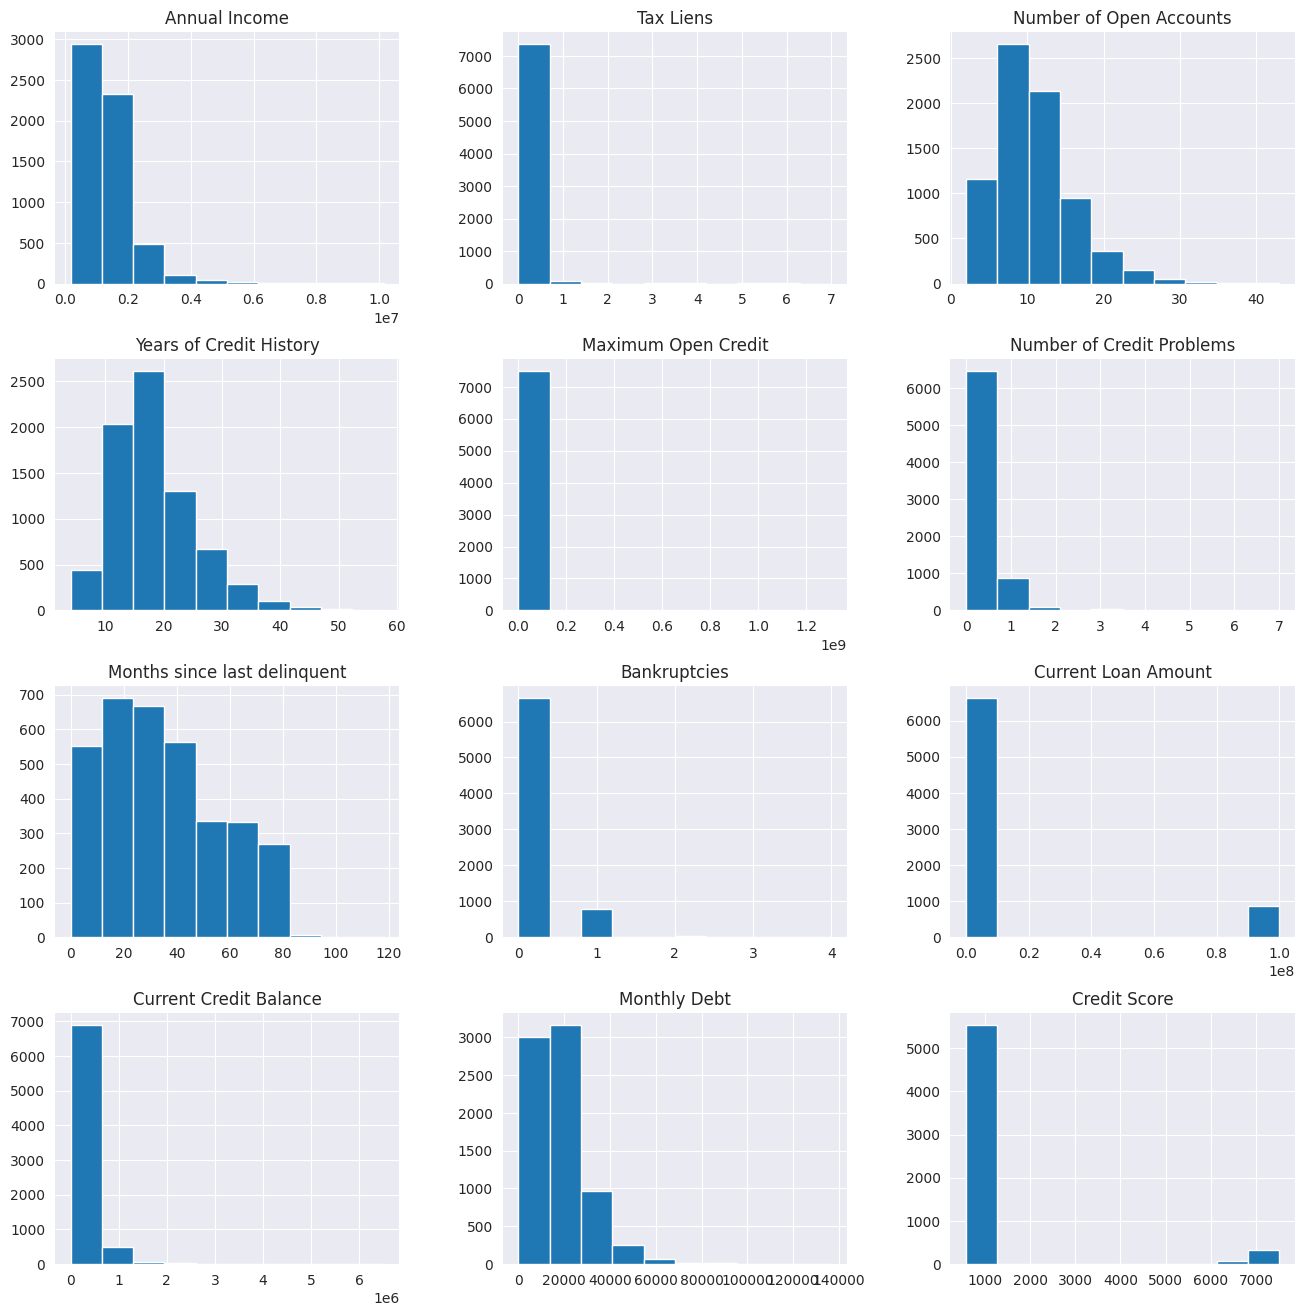

In [11]:
h = ds[float_columns].hist(figsize=(16,16))
sns.despine(left=True, bottom=True)

In [13]:
# Проверка пропусков
ds.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

<AxesSubplot:>

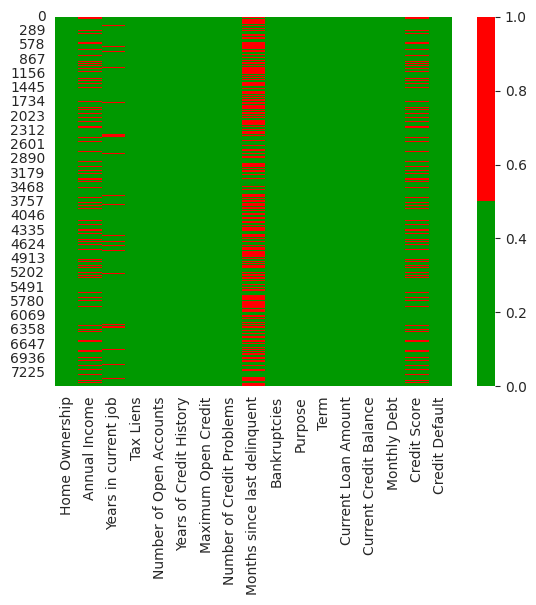

In [14]:
colours = ['#009900', '#ff0000']
sns.heatmap(ds.isnull(), cmap=sns.color_palette(colours))

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
Annual Income,1.000000,0.066245,0.188524,0.186531,0.062218,-0.015407,-0.101787,-0.066877,0.032082,0.386481,0.584819,-0.037832,-0.101375
Tax Liens,0.066245,1.000000,-0.005360,0.009109,-0.002410,0.595339,0.052446,0.057360,-0.007835,-0.010195,0.027211,0.010581,0.024368
Number of Open Accounts,0.188524,-0.005360,1.000000,0.144819,0.023897,-0.017813,-0.032740,-0.019130,0.001346,0.267325,0.413904,0.016095,0.028884
Years of Credit History,0.186531,0.009109,0.144819,1.000000,0.029247,0.071259,-0.015375,0.085699,0.010623,0.217856,0.191978,-0.015683,-0.020567
Maximum Open Credit,0.062218,-0.002410,0.023897,0.029247,1.000000,-0.004750,-0.003849,-0.011650,-0.002334,0.088090,0.010197,-0.009136,-0.014275
Number of Credit Problems,-0.015407,0.595339,-0.017813,0.071259,-0.004750,1.000000,0.139905,0.730751,-0.008596,-0.124137,-0.042252,-0.018473,0.020088
Months since last delinquent,-0.101787,0.052446,-0.032740,-0.015375,-0.003849,0.139905,1.000000,0.162710,0.000459,-0.027198,-0.057702,-0.004395,0.002598
Bankruptcies,-0.066877,0.057360,-0.019130,0.085699,-0.011650,0.730751,0.162710,1.000000,-0.005987,-0.142849,-0.079579,-0.027488,0.001648
Current Loan Amount,0.032082,-0.007835,0.001346,0.010623,-0.002334,-0.008596,0.000459,-0.005987,1.000000,0.016672,-0.009382,-0.108552,-0.226522
Current Credit Balance,0.386481,-0.010195,0.267325,0.217856,0.088090,-0.124137,-0.027198,-0.142849,0.016672,1.000000,0.504964,-0.006159,-0.019522


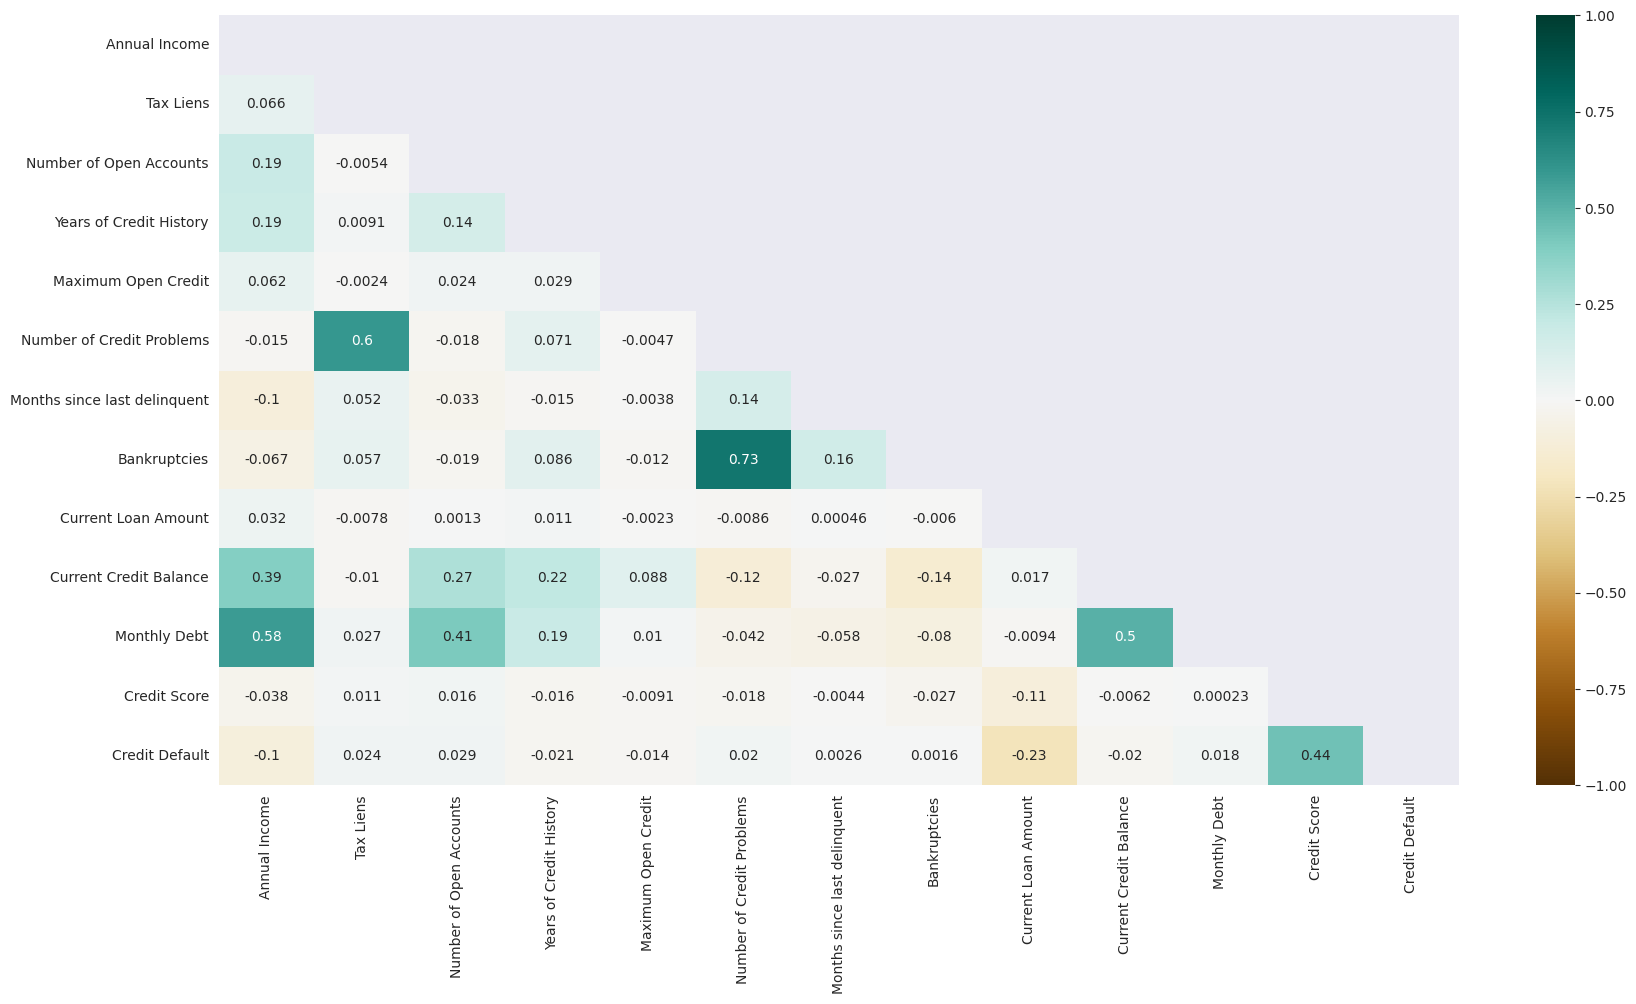

In [15]:
plt.figure(figsize=(20,10))
c= ds.corr()
cor_matrix_mask = np.triu(np.ones_like(c, dtype=bool))
sns.heatmap(c,cmap="BrBG",annot=True, vmin=-1, vmax=1, mask=cor_matrix_mask)
c

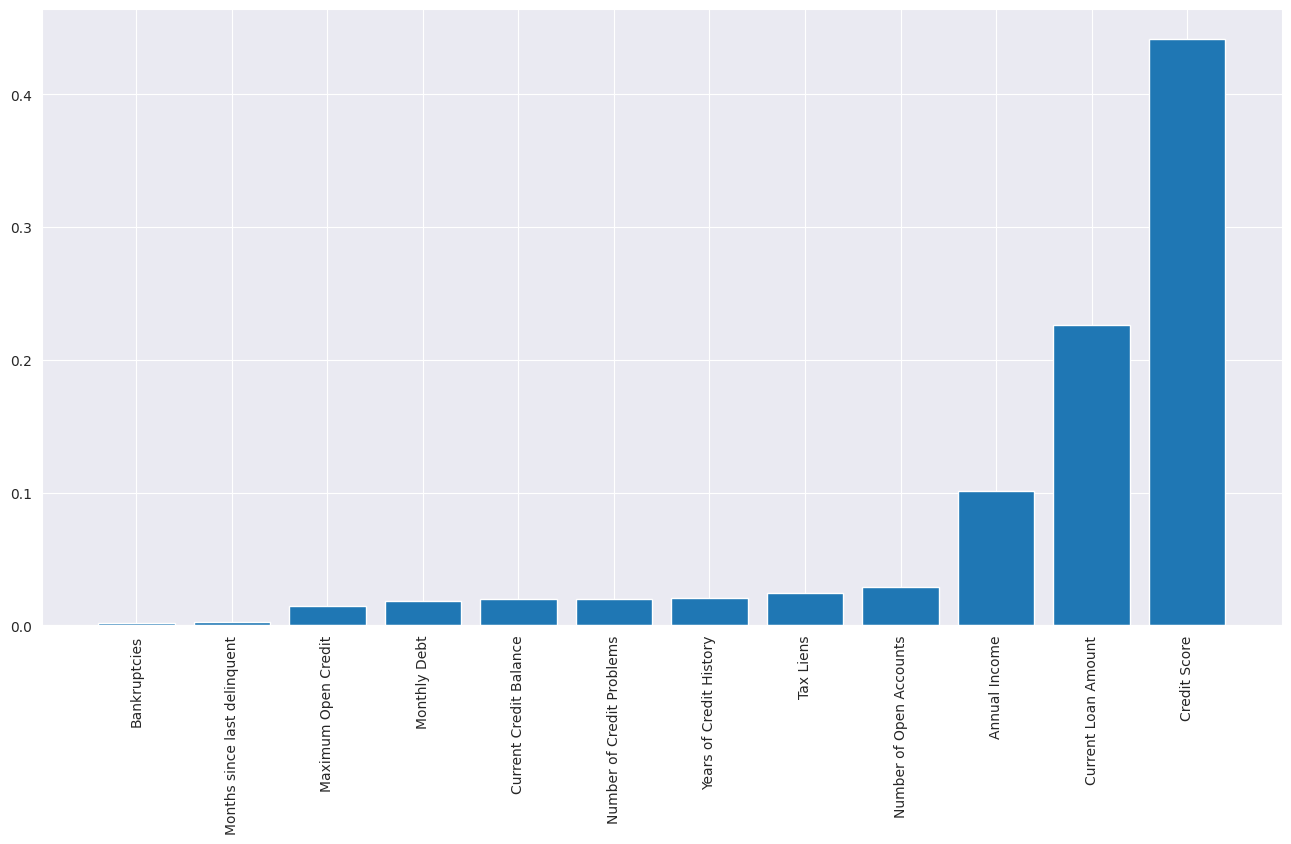

In [16]:
price_corr = ds.corr().abs()
price_corr = price_corr.unstack().sort_values()['Credit Default']

plt.figure(figsize = (16, 8))
plt.bar(list(price_corr.keys())[:-1], list(price_corr)[:-1])
plt.xticks(rotation=90)
plt.show()

### Обработка выбросов

In [18]:
for float_column in float_columns:
    q1 = np.percentile(ds[float_column], 25, interpolation='midpoint')
    q3 = np.percentile(ds[float_column], 75, interpolation='midpoint')
    upper = q3 + 1.5 * q1
    ds.loc[ds[float_column] > upper, float_column] = upper

In [20]:
# Нормализация
scaler = preprocessing.StandardScaler()
ds[float_columns] = scaler.fit_transform(ds[float_columns])

### Обработка пропусков

Преобразуем поле Years in current job в int убрав лишнее

In [21]:
def fix_year(row):
    year = row['Years in current job']
    if not year or pd.isnull(year):
        year = '0'
    else:
        year = str(year).replace(' years','').replace('+','').replace(' year','')
        if year == '< 1':
            year = '0'
    row['Years in current job'] = year
    return row
ds = ds.apply(fix_year, axis=1)
ds['Years in current job'] = ds['Years in current job'].astype(int)

Для поля Bankruptcies заполним пропуски нулями и преобразуем тип

In [22]:
ds['Bankruptcies'] = ds['Bankruptcies'].fillna(0.00)
ds['Bankruptcies'] = ds['Bankruptcies'].astype(np.int)
ds['Bankruptcies'].unique()

array([ 2,  0,  8,  5, 11])

Остльные пропуски заполним медианными значениями

In [23]:
for col in ['Annual Income', 'Months since last delinquent', 'Credit Score','Years in current job']:
    median = ds[col].median()
    ds[col] = ds[col].fillna(median)

### Обработка категориальных признаков

In [24]:
home_ownership_map = {'Own Home': 3, 'Home Mortgage': 2, 'Rent': 1, 'Have Mortgage': 2}
ds['Home Ownership'] = ds['Home Ownership'].map(home_ownership_map)

In [26]:
ds['Purpose'].unique()

array(['debt consolidation', 'other', 'home improvements', 'take a trip',
       'buy a car', 'small business', 'business loan', 'wedding',
       'educational expenses', 'buy house', 'medical bills', 'moving',
       'major purchase', 'vacation', 'renewable energy'], dtype=object)

In [27]:
le = preprocessing.LabelEncoder()
ds['Purpose'] = le.fit_transform(ds['Purpose'])

In [29]:
# Term
term_map = { 'Short Term': 0, 'Long Term': 1 }
ds['Term'] = ds['Term'].map(term_map)

### Добавление новых признаков

Добавим два признака
- Отношение дохода к ежемесячному долгу
- Отношение дохода к максимально открытому кредиту

In [32]:
ds['ci_ratio'] = ds['Annual Income']/ds['Monthly Debt']
ds['max_cr_ratio'] = ds['Annual Income']/ds['Maximum Open Credit']

### Балансировка классов

In [34]:
ds[TARGET].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

<AxesSubplot:>

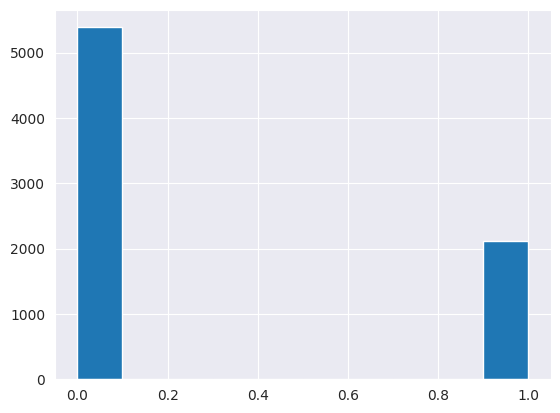

In [35]:
ds[TARGET].hist()

Как видно присутсвует дизбаланс классов
Продублируем ряды с недостающими классами

In [36]:
rat = len(ds.loc[ds[TARGET]==0])//len(ds.loc[ds[TARGET]==1])
rat

2

In [37]:
ds_1 = ds.loc[ds[TARGET]==1]
ds_1 = ds_1.loc[ds_1.index.repeat(rat)]
ds_n = pd.concat([ds.loc[ds[TARGET]==0], ds_1]).sample(frac=1)

<AxesSubplot:>

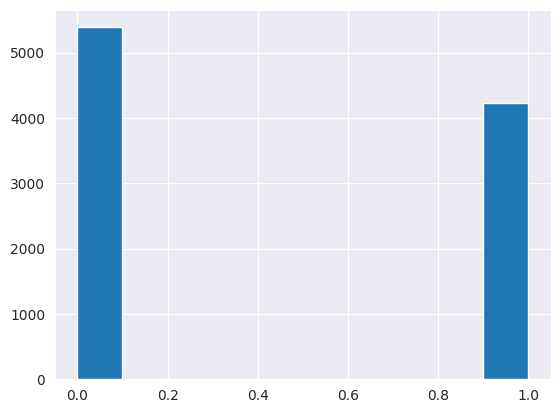

In [38]:
ds_n[TARGET].hist()

### Подбор моделей

Проверим 3 модели
- LogisticRegression
- CatBoostClassifier
- RandomForestClassifier

Модели уже используют лучшие параметры, для подбора параметров использовался GridSearchCV. Для быстрой работы скрипта опустил эти моменты.

In [41]:
X = ds_n[ds_n.columns.difference([TARGET])]
y = ds_n[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=56)

##### LogisticRegression

In [74]:
best_params = {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
model_lr = LogisticRegression(**best_params)
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

print(classification_report(y_test, y_test_pred))
print('F1 score: ', f1_score(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.66      0.85      0.75      1071
           1       0.71      0.46      0.56       852

    accuracy                           0.68      1923
   macro avg       0.69      0.66      0.65      1923
weighted avg       0.69      0.68      0.66      1923

F1 score:  0.5594306049822064


In [70]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=False, n_estimators=250)
rfc.fit(X_train, y_train)
y_test_pred = rfc.predict(X_test)

print(classification_report(y_test, y_test_pred))
print('F1 score: ', f1_score(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1071
           1       0.91      0.88      0.90       852

    accuracy                           0.91      1923
   macro avg       0.91      0.91      0.91      1923
weighted avg       0.91      0.91      0.91      1923

F1 score:  0.89815366289458


#### CatBoostClassifier

In [73]:
best_params = {
    'silent':True,'cat_features':['Home Ownership','Purpose','Term'],'n_estimators':500, 'max_depth':6,'random_state':41
}
model_catb = catb.CatBoostClassifier(**best_params)
model_catb.fit(X_train, y_train)
y_test_pred = model_catb.predict(X_test)
print(classification_report(y_test, y_test_pred))
print('F1 score: ', f1_score(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80      1071
           1       0.77      0.67      0.71       852

    accuracy                           0.76      1923
   macro avg       0.76      0.75      0.75      1923
weighted avg       0.76      0.76      0.76      1923

F1 score:  0.7126725219573401


### Выбор наилучшей модели
Очевидно что RandomForestClassifier имеет лучшие результаты.


### Проверка качества, борьба с переобучением

In [79]:
from sklearn.metrics import confusion_matrix
y_pred = rfc.predict(X_test)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['True 0', 'True 1'], columns = ['Pred 0', 'Pred 1'])
print(conf_matrix)
print('Recall: ', recall_score(y_test, y_pred))

        Pred 0  Pred 1
True 0     998      73
True 1      98     754
Recall:  0.8849765258215962


## Прогнозирование на тестовом датасете

Для удобства обернем всю предобработку данных в отдельный класс

In [206]:
class Preprocessor:
    HOME_OWNERSHIP_MAP = {'Own Home': 3, 'Home Mortgage': 2, 'Rent': 1,
                          'Have Mortgage': 2}
    TERM_MAP = {'Short Term': 0, 'Long Term': 1}
    MEDIAN_COLS = ['Annual Income', 'Months since last delinquent',
                    'Credit Score','Years in current job']

    def __init__(self, target):
        self.target = target
        self.medians  = {}
        self.uppers = {}
        self.float_columns = []
        self.le = preprocessing.LabelEncoder()
        self.scaler = preprocessing.StandardScaler()

    def fit(self, dataset):
        self.le.fit(dataset['Purpose'])
        dataset = self.__fixes(dataset)
        self.float_columns = dataset.select_dtypes(include=['float64']).columns

        tmp_ds = dataset.copy()
        for float_column in self.float_columns:
            q1 = np.percentile(dataset[float_column], 25, interpolation='midpoint')
            q3 = np.percentile(dataset[float_column], 75, interpolation='midpoint')
            self.uppers[float_column] = q3 + 1.5 * q1
            tmp_ds.loc[tmp_ds[float_column] > self.uppers[float_column], float_column] = self.uppers[float_column]

        for m_col in self.MEDIAN_COLS:
            self.medians[m_col] = dataset[m_col].median()

        self.scaler.fit(tmp_ds[self.float_columns])

    def ballance(self, dataset):
        """Балансировка классов."""
        rat = len(dataset.loc[dataset[self.target] == 0]) // len(dataset.loc[dataset[self.target] == 1])
        ds_1 = dataset.loc[dataset[self.target] == 1]
        ds_1 = ds_1.loc[ds_1.index.repeat(rat)]
        ds_n = pd.concat([dataset.loc[dataset[self.target] == 0], ds_1]).sample(frac=1)
        return ds_n

    def transform(self, dataset):
        """Трансформация."""
        dataset = self.__fixes(dataset)
        dataset = self.__outliers(dataset)
        dataset = self.__fill(dataset)
        dataset = self.__categories(dataset)
        dataset[self.float_columns] = self.scaler.fit_transform(dataset[self.float_columns])

        dataset = self.__new_features(dataset)
        return dataset

    def fit_transform(self, dataset):
        self.fit(dataset)
        return self.transform(dataset)

    def __fixes(self, dataset):
        def fix_year(row):
            year = row['Years in current job']
            if not year or pd.isnull(year):
                year = '0'
            else:
                year = str(year).replace(' years', '').replace('+','').replace(' year', '')
                if year == '< 1':
                    year = '0'
            row['Years in current job'] = year
            return row
        dataset = dataset.apply(fix_year, axis=1)
        dataset['Years in current job'] = dataset['Years in current job'].astype(int)
        return dataset

    def __fill(self, dataset):
        """Заполнение пропусков."""

        for col in self.MEDIAN_COLS:
            dataset[col] = dataset[col].fillna(self.medians[col])

        dataset['Bankruptcies'] = dataset['Bankruptcies'].fillna(0.00)
        dataset['Bankruptcies'] = dataset['Bankruptcies'].astype(np.int)
        # dataset['Purpose'] = dataset['Purpose'].fillna('other')
        return dataset

    def __new_features(self, dataset):
        """Добавление новых фич."""
        dataset['ci_ratio'] = dataset['Annual Income'] / dataset['Monthly Debt']
        dataset['max_cr_ratio'] = dataset['Annual Income'] / dataset['Maximum Open Credit']
        return dataset

    def __categories(self, dataset):
        """Обработка категориальных признаков."""
        dataset['Term'] = dataset['Term'].map(self.TERM_MAP)
        dataset['Purpose'] = self.le.transform(dataset['Purpose'])
        dataset['Home Ownership'] = dataset['Home Ownership'].map(self.HOME_OWNERSHIP_MAP)

        return dataset

    def __outliers(self, dataset):
        """Обработка выбросов."""
        for float_column in self.float_columns:
            dataset.loc[dataset[float_column] > self.uppers[float_column], float_column] = self.uppers[float_column]
        return dataset


In [220]:
train_ds_orig = pd.read_csv(TRAIN_DATASET_PATH)
test_ds_orig = pd.read_csv(TEST_DATASET_PATH)

In [208]:
prep_prc = Preprocessor(target=TARGET)

In [209]:
prep_prc.fit(train_ds_orig)
train_ds = prep_prc.transform(train_ds_orig)
test_ds = prep_prc.transform(test_ds_orig)

In [215]:
train_b = prep_prc.ballance(train_ds)
X_train = train_b[train_b.columns.difference([TARGET])]
y_train = train_b[TARGET]

In [216]:
model = RandomForestClassifier(bootstrap=False, n_estimators=250)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, n_estimators=250)

In [223]:
predictions = model.predict(test_ds)

In [230]:
pd.DataFrame(predictions).to_csv(OUTPUT_PREDICTIONS_PATH,index=False)
test_ds_orig[TARGET] = predictions
test_ds_orig.to_csv(OUTPUT_DATA_PATH, index=False)